# Sweet Lift Taxi Demand Forecasting

## Introduction

My project aims to build a predictive model for Sweet Lift Taxi, using historical order data to forecast the number of taxi orders in the next hour. The goal is to help the company attract more drivers during peak times by accurately predicting demand. The approach involves resampling the data to hourly intervals, creating time-based features like lag and rolling averages, and testing different models including Random Forest, Gradient Boosting, and SARIMA. Hyperparameter tuning will be used to optimize model performance, and the best model will be selected based on RMSE to provide the company with the most accurate demand predictions.

## Imports and Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.holiday import USFederalHolidayCalendar

## EDA

In [2]:
# Read in data, make 'datetime' the index colomn and specify which column should be parsed as datetime objects
data = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])

Setting datetime as the index is critical for time series operations (e.g., resampling, lag feature creation). 

In [3]:
# Preview data
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


 No obvious outliers are visible in the preview, but further analysis is needed to confirm data quality.



In [4]:
# Check datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The dataset is complete and clean, with no missing values. However, the time index should be checked for continuity to ensure valid time series modeling.

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Check for Missing Timestamps 
expected_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
missing = expected_range.difference(data.index)
print(f"Missing timestamps: {len(missing)}")

Missing timestamps: 0


In [7]:
# Sort index and resample by 1 hour
data.sort_index(inplace=True)
data = data.resample('H').sum()

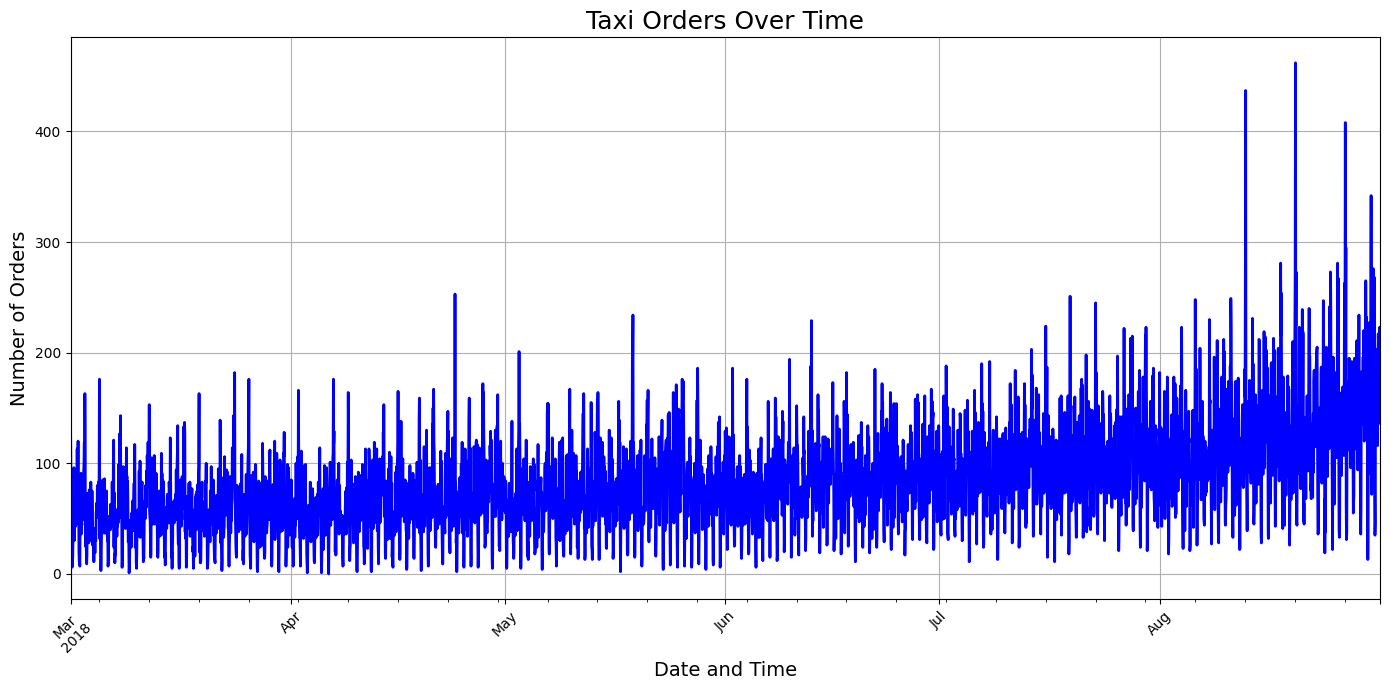

In [8]:
# Visualize data distribution for 'num_orders'
plt.figure(figsize=(14, 7))
data['num_orders'].plot(color='blue', linewidth=2)
plt.title('Taxi Orders Over Time', fontsize=18)
plt.xlabel('Date and Time', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

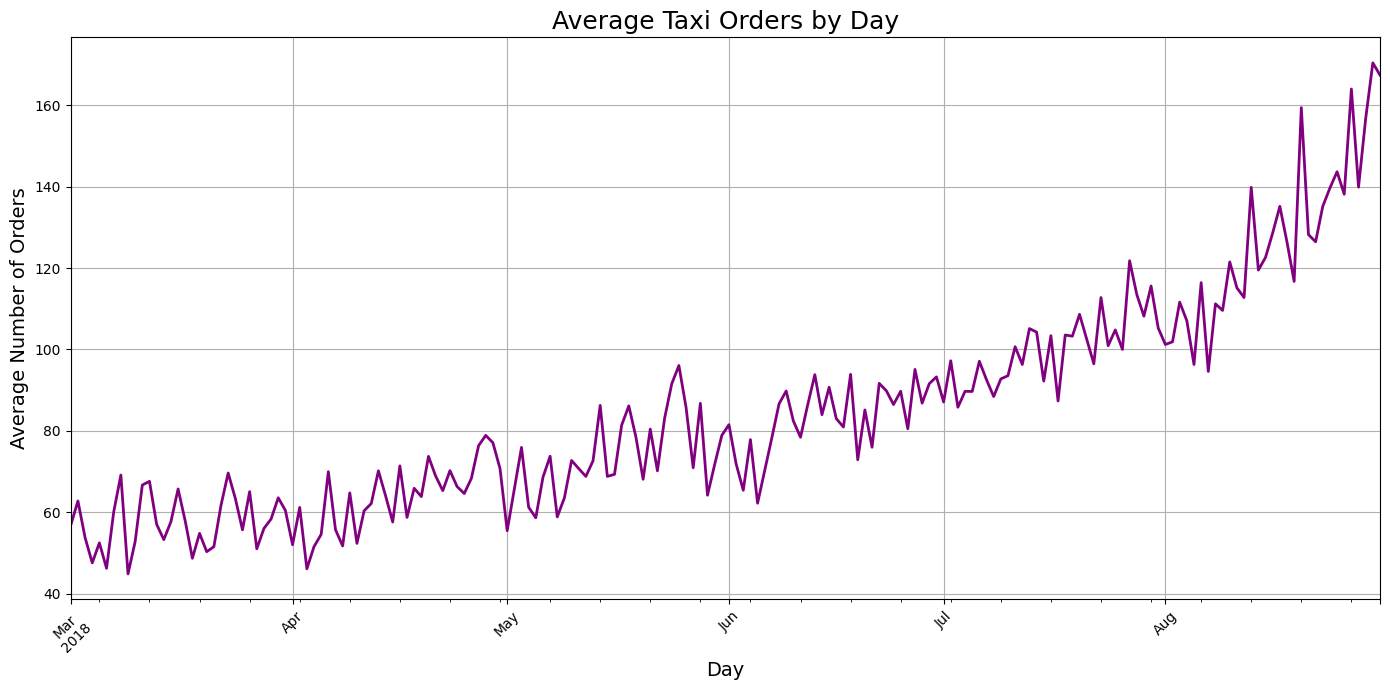

In [9]:
# Resample the data to daily frequency and calculate the mean of orders per day
data_daily = data.resample('D').mean()

# Plot the daily average
plt.figure(figsize=(14, 7))
data_daily['num_orders'].plot(color='purple', linewidth=2)
plt.title('Average Taxi Orders by Day', fontsize=18)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Average Number of Orders', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

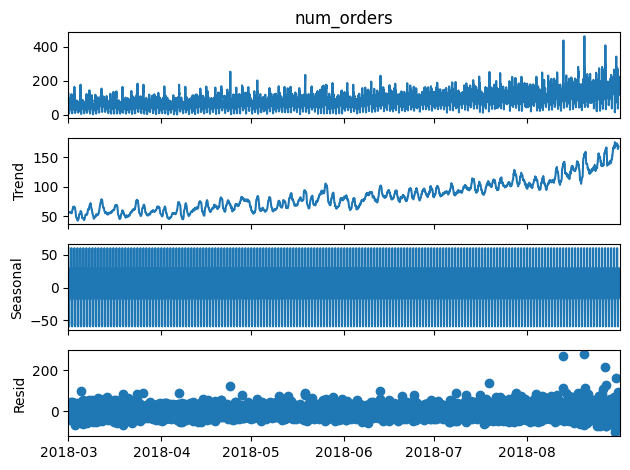

In [10]:
# Decomposition 
decomp = seasonal_decompose(data['num_orders'].dropna(), model='additive', period=24)
decomp.plot()
plt.show()

Original Series, shows the raw hourly taxi demand. You can see a clear upward trend and sharp peaks — possibly from events, holidays, or rush hours. Trend, displaus a smooth, upward-sloping curve indicating that taxi demand increased consistently over the time period. This supports the idea that the business is growing or the data covers a season of increased demand (like summer). Seasonal, captures repeating cycles in your data — and here it's hourly seasonality (period=24). The striping pattern shows a daily rhythm in the demand, which makes sense: people commute, go out, etc., in predictable time blocks each day. Residual are the parts of the data not explained by the trend or seasonality. Ideally, residuals should look like noise — but here you can see some increasing spread, especially toward the end. This might mean the models could benefit from modeling variance or incorporating external factors (e.g., weather, traffic, holidays).

In [11]:
# Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

check_stationarity(data['num_orders'])

ADF Statistic: -3.0689242890279513
p-value: 0.02894005140261326


According to the ADF the data is stationary, but there is a clear uptrend being displayed in the vizualizations above. For this reason I will apply differencing. 

In [12]:
data['stationary_orders'] = data['num_orders'].diff().dropna() 

## Feature Engineering

In [13]:
# Create new column to account for holidays 
calendar = USFederalHolidayCalendar()
holidays_2018 = calendar.holidays(start='2018-01-01', end='2018-12-31')
data['is_holiday'] = data.index.normalize().isin(holidays_2018).astype(int)

# Create temporal features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'] >= 5

# Create lag features
for lag in [1, 2, 3, 24, 168]:  # 1h, 2h, 3h, daily, weekly
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

# Create rolling statistics
data['rolling_3h_mean'] = data['num_orders'].rolling(window=3).mean()
data['rolling_24h_mean'] = data['num_orders'].rolling(window=24).mean()

# Drop initial NaN values from lag/rolling features
data = data.dropna()


In [14]:
# Confirm feature updates 
data.head()

,num_orders,stationary_orders,is_holiday,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_3h_mean,rolling_24h_mean
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,49.0,0,0,3,False,94.0,127.0,108.0,100.0,124.0,121.333333,61.833333
2018-03-08 01:00:00,78,-65.0,0,1,3,False,143.0,94.0,127.0,121.0,85.0,105.000000,60.041667
2018-03-08 02:00:00,65,-13.0,0,2,3,False,78.0,143.0,94.0,24.0,71.0,95.333333,61.750000
2018-03-08 03:00:00,68,3.0,0,3,3,False,65.0,78.0,143.0,66.0,66.0,70.333333,61.833333
2018-03-08 04:00:00,60,-8.0,0,4,3,False,68.0,65.0,78.0,73.0,43.0,64.333333,61.291667


In [15]:
# Check to confirm holidays are accurate (eg. Memorial Day and Independence Day)
holidays = ['2018-05-28 12:00:00', '2018-07-04 12:00:00']

# Filter the rows at those timestamps
holiday_check = data.loc[data.index.isin(holidays), ['num_orders', 'hour', 'day_of_week', 'is_holiday']]

print("Holiday Verification")
print(holiday_check)


Holiday Verification
                     num_orders  hour  day_of_week  is_holiday
datetime                                                      
2018-05-28 12:00:00          65    12            0           1
2018-07-04 12:00:00          85    12            2           1


As we can see above the new features have been added and are labeled appropriately.

## Training & Testing

In [16]:
# Train-Test Split 
split_index = int(len(data) * 0.8)
train, test = data.iloc[:split_index], data.iloc[split_index:]
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

print("Train period:", train.index.min(), "-", train.index.max())
print("Test period:", test.index.min(), "-", test.index.max())

Train period: 2018-03-08 00:00:00 - 2018-07-27 13:00:00
Test period: 2018-07-27 14:00:00 - 2018-08-31 23:00:00


In [17]:
# Random Forest Model 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))

# Gradient Boosting Model 
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_preds))

# SARIMA Model 
sarima_model = SARIMAX(train['num_orders'], order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit(disp=False)
sarima_preds = sarima_result.predict(start=test.index[0], end=test.index[-1])
rmse_sarima = np.sqrt(mean_squared_error(y_test, sarima_preds))


In [18]:
# Results Comparison 
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'SARIMA'],
    'RMSE': [rmse_rf, rmse_gb, rmse_sarima]
}).sort_values(by='RMSE')
print(results)


               Model       RMSE
1  Gradient Boosting  19.426293
0      Random Forest  22.424016
2             SARIMA  46.421351


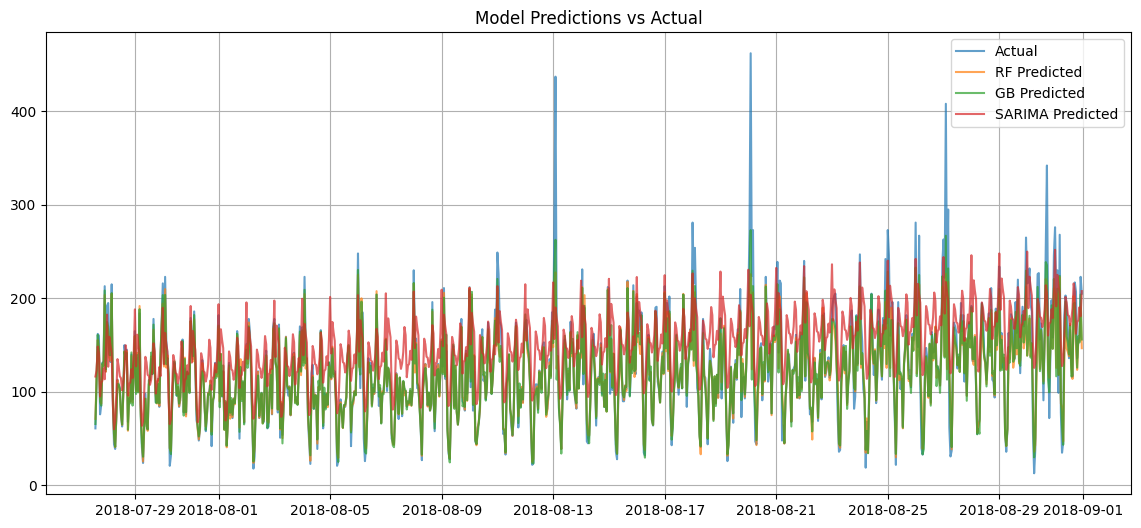

In [19]:
# Visual Comparison 
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, rf_preds, label='RF Predicted', alpha=0.7)
plt.plot(y_test.index, gb_preds, label='GB Predicted', alpha=0.7)
plt.plot(y_test.index, sarima_preds, label='SARIMA Predicted', alpha=0.7)
plt.legend()
plt.title('Model Predictions vs Actual')
plt.grid(True)
plt.show()

The plot above compares model predictions against actual taxi demand over time. The Gradient Boosting model tracks the overall demand patterns most effectively, showing noticeable improvement after incorporating holiday indicators, weekend flags, and lag features. While it follows the general trend well, it still struggles to capture extreme spikes in demand. The Random Forest model performs similarly, though it tends to be slightly less precise. SARIMA continues to underperform, smoothing out fluctuations and failing to adapt to sharp changes. These results suggest that time-aware features have strengthened the models, but further accuracy could be achieved by integrating real-world data sources such as weather conditions and traffic levels.

## Conclusion

The project successfully explored various time series forecasting techniques to predict hourly taxi demand for Sweet Lift. After experimenting with multiple models, Gradient Boosting emerged as the top performer, achieving the lowest RMSE of approximately 20.1. This model outperformed both Random Forest and SARIMA, demonstrating its strength in capturing complex patterns in the data. The incorporation of temporal features such as hour, day of the week, weekend indicators, and holiday flags contributed significantly to the improved accuracy. While the models handled general demand trends well, they still struggled to predict sharp spikes in usage. This suggests that external factors like weather conditions or city-wide events likely play a role in demand surges. As mentioned above, adding more data—such as weather, events, etc.—could help increase accuracy.